In [1]:
    import os
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
    #Data prepare
    import tensorflow as tf
    import random
    import segmentation_models as sm
    import matplotlib.pyplot as plt

    def trainGenerator(batch_size, train_path, image_folder, mask_folder, target_size, image_color_mode="rgb",
                       mask_color_mode="grayscale"):
        image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, samplewise_center=True, 
                                                                        samplewise_std_normalization=True,
                                                                        zoom_range=0.5)  
        mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, zoom_range=0.5)
        random_value = random.randint(1,200)

        image_generator = image_datagen.flow_from_directory(
            train_path,
            classes=[image_folder],
            class_mode=None,
            color_mode=image_color_mode,
            target_size=target_size,
            batch_size=batch_size,
            shuffle=True, seed=random_value)

        mask_generator = mask_datagen.flow_from_directory(
            train_path,
            classes=[mask_folder],
            class_mode=None,
            color_mode=mask_color_mode,
            target_size=target_size,
            batch_size=batch_size, shuffle=True, seed =random_value)



        train_generator = zip(image_generator, mask_generator)

        # return image_datagen.flow(image_generator, mask_generator, batch_size=batch_size)
        for (img, mask) in train_generator:
            yield (img, mask)



    def validationGenerator(batch_size, validation_path, image_folder, mask_folder, target_size, image_color_mode="rgb",
                            mask_color_mode="grayscale"):
        image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255, samplewise_center=True, samplewise_std_normalization=True)  # preprocessing_function=preprocess_input
        mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
        random_value = random.randint(1,200)

        image_generator = image_datagen.flow_from_directory(
            validation_path,
            classes=[image_folder],
            class_mode=None,
            color_mode=image_color_mode,
            target_size=target_size,
            batch_size=batch_size,
            shuffle=True, seed = random_value)  # shuffle=False
        mask_generator = mask_datagen.flow_from_directory(
            validation_path,
            classes=[mask_folder],
            class_mode=None,
            color_mode=mask_color_mode,
            target_size=target_size,
            batch_size=batch_size,
            shuffle=True, seed = random_value)

        validation_generator = zip(image_generator, mask_generator)
        # return image_datagen.flow(image_generator, mask_generator, batch_size=batch_size)
        for (img, mask) in validation_generator:
            yield (img, mask)


Segmentation Models: using `keras` framework.


In [3]:
    from keras_unet_collection import models
    model = models.transunet_2d((1024, 1024, 3), filter_num=[16, 32, 64, 128, 256, 512], n_labels=1, stack_num_down=2, stack_num_up=2,
                                    embed_dim=192, num_mlp=768, num_heads=12, num_transformer=12,
                                    activation='ReLU', mlp_activation='GELU', output_activation='Sigmoid', 
                                    batch_norm=True, pool=True, unpool='bilinear', name='transunet')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-4),
        loss=[sm.losses.jaccard_loss,sm.losses.binary_crossentropy],loss_weights=[0.7,0.3],
        #loss=[sm.losses.jaccard_loss,sm.losses.binary_crossentropy],loss_weights=[0.9,0.1],
        metrics=[sm.metrics.iou_score],#,sm.metrics.iou_score
    )
    model.summary()

Model: "transunet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
transunet_down0_0 (Conv2D)      (None, 1024, 1024, 1 432         input_1[0][0]                    
__________________________________________________________________________________________________
transunet_down0_0_bn (BatchNorm (None, 1024, 1024, 1 64          transunet_down0_0[0][0]          
__________________________________________________________________________________________________
transunet_down0_0_activation (R (None, 1024, 1024, 1 0           transunet_down0_0_bn[0][0]       
____________________________________________________________________________________

C:\Users\ziheng.yang\Anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [4]:
    model.load_weights('C:/Users/ziheng.yang/Desktop/segmentation/00github/4 deep learning models/Coarse_segmentation.hdf5')


    test_length = 7
    batch_size = 1

    test_path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/validation'
    testGene = validationGenerator(batch_size, test_path, 'img', 'mask',
                                         target_size=(1024, 1024))

    print(model.metrics_names)
    model.evaluate_generator(testGene, steps=test_length//batch_size)

[]


C:\Users\ziheng.yang\Anaconda3\envs\tf2.5\lib\site-packages\tensorflow\python\keras\engine\training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Found 7 images belonging to 1 classes.
Found 7 images belonging to 1 classes.


[0.1686178743839264, 0.7591173052787781]

In [5]:
    import skimage.io as io
    import numpy as np
    def saveResult(path,npyfile,file_list):

        #print(path)
        for i,item in enumerate(npyfile):
            img=item
            #img=item[:,:,0]
            img[img>0.5]=255
            img[img<=0.5]=0
            #print(np.unique(img))
            if not os.path.exists(path):
                os.makedirs(path)
            #cv2.imwrite(path + str(i) + '.tif', img)
            io.imsave(path + file_list[i], img)

    if __name__ == '__main__':
     path_test = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/'
     file_list = os.listdir(path_test+'img')
     print(file_list)


['1.png', '121.png', '122.png', '2.png', '3.png', '34.png', '35.png']


In [6]:
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                                   samplewise_center=True,
                                                                   samplewise_std_normalization=True)  
    
    test_generator = test_datagen.flow_from_directory(
        path_test,
        target_size=(1024, 1024), shuffle=False)

    save_prediction_path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/prediction/'
    if not os.path.exists(save_prediction_path):
        os.makedirs(save_prediction_path)
    
    
    result = model.predict(test_generator, verbose=0)
    saveResult(save_prediction_path, result, file_list)

Found 7 images belonging to 1 classes.


Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\ZIHENG~1.YAN\AppData\Local\Temp\5/ipykernel_2484/481416822.py:15: UserWarning: E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/prediction/122.png is a low contrast image
  io.imsave(path + file_list[i], img)
Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\ZIHENG~1.YAN\AppData\Local\Temp\5/ipykernel_2484/481416822.py:15: UserWarning: E:/ziheng-projects/t

In [7]:
    prediction_gt_path='E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/prediction/'
    file_list = os.listdir(prediction_gt_path)

    iou=0
    nb=0
    import cv2
    import numpy as np
    def IOU(img,gt):
        k = 0.5
        iou_score=0
        intersection = np.sum(img[gt>k]>k)
        union = np.sum(img[img>k]>k)+np.sum(gt[gt>k]>k)-intersection
        if (union!=0):
         iou_score = np.sum(intersection)/np.sum(union)
        if (union==0):
         iou_score = 1
         print('1 union = 0')
        print(iou_score)
        return iou_score

    for file in file_list: 
        prediction= cv2.imread(prediction_gt_path + file,0)
    #     print(np.unique(prediction))
    #     print('#####################################')    
        gt_path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/validation/mask/'
        gt = cv2.imread(gt_path+file,0)

        # dsize
        dsize = (2048, 2048)

        # resize image
        output = cv2.resize(prediction, dsize)
        cv2.imwrite(prediction_gt_path + file, output)


In [8]:
    ################# New metric for evaluation

In [9]:
    def instance_segmentation_metrics_sparse(y, pred, t1=0.5, t2=0.5):
        """
            Computes the IoU based on sparse representation of masks : store coordinates of non-zero elemnts rather than whole image
        """

        def IoU_sparse(m1, m2):
            intersection = len(m1.intersection(m2))
            union = len(m1.union(m2))
            return intersection / union

        def get_sparse_masks(b):
            contours, _ = cv2.findContours(b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            masks = []
            for contour in contours:
                m = cv2.drawContours(np.zeros_like(b), [contour], contourIdx=-1, color=1, thickness=-1)
                m = set([tuple(c) for c in np.argwhere(m)])
                masks.append(m)

            return masks

        tp, fp, fn = 0, 0, 0

        # binarize the images
        y = (y > t1).astype('uint8').squeeze()
        pred = (pred > t1).astype('uint8').squeeze()

        # get binary mask of objects
        y_masks = get_sparse_masks(y)
        pred_masks = get_sparse_masks(pred)

        # if no object in prediction, stop
        if len(pred_masks) == 0:
            return 0, 0, 0, len(y_masks)

        # if more objects in ground-truth, add FN
        if len(y_masks) > len(pred_masks):
            fn += len(y_masks) - len(pred_masks)

        # if more objects in prediction, add FP
        if len(pred_masks) > len(y_masks):
            fp += len(pred_masks) - len(y_masks)

        # computes IoU for every pair of objects in ground-truth and prediction
        all_IoU = []
        for m1 in y_masks:
            for m2 in pred_masks:
                all_IoU.append(IoU_sparse(m1, m2))

        # create list with pairs : ((ground-truth object ID, prediction object ID), IoU)
        i, j = np.meshgrid(range(len(y_masks)), range(len(pred_masks)), indexing='ij')
        pos = np.stack((i, j), axis=-1)
        pos = np.reshape(pos, (-1, 2))
        pos_and_iou = [(p, iou) for p, iou in zip(pos, all_IoU)]

        # sort list with decreasing IoU
        pos_and_iou = sorted(pos_and_iou, key=lambda tup: tup[1], reverse=True)

        y_selected = []
        pred_selected = []
        IOU = []

        # iterate over sorted list, and pair ground-truth and prediction objects ID if not already paired
        for (y_id, pred_id), p in pos_and_iou:
            if y_id not in y_selected and pred_id not in pred_selected:
                y_selected.append(y_id)
                pred_selected.append(pred_id)
                IOU.append(p)

                # if we have used all ground-truth or prediction objects, stop
                if len(y_selected) == len(y_masks) or len(pred_selected) == len(pred_masks):
                    break

        # for every IoU, if IoU greater than threshold then account for TP, otherwise account for FP and FN
        for i in IOU:
            if i > t2:
                tp += 1
            else:
                fp += 1
                fn += 1

        # average precision
        ap = tp / (tp + fp + fn)

        return ap, tp, fp, fn



In [10]:
    def Fill_hole(image):
       img1=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
       cnts, hierarchy = cv2.findContours(img1, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
       c = sorted(cnts, key=cv2.contourArea, reverse=True)
       im_rgb = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
       #print(hierarchy)
        
       for i in range(0,len(c)):
           cv2.drawContours(im_rgb, [c[i]], 0, (255, 255, 255), cv2.FILLED) 


       return im_rgb

In [11]:
    import numpy as np
    import cv2
    import os

    if __name__ == '__main__':
        Path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/test/prediction/04.28/3SpatialAug/prediction/'
        gt_path = 'E:/ziheng-projects/test_jerome/segmentation/data/aLatest/Global/validation/mask/'
        FileList = os.listdir(Path)
        gt_list = []
        predit_list = []
        for predit_name in FileList:
            gt_name = predit_name#.split('.png')[0] + '_GT.png'
            gt_img=cv2.imread(gt_path + gt_name, cv2.IMREAD_GRAYSCALE)/255.

            pred_img=cv2.imread(Path + predit_name)
            #pred_img=cv2.resize(pred_img, (2048, 2048))
            pred_img=Fill_hole(pred_img)
            pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2GRAY)/255.
           # kernel = np.ones((30, 30), np.uint8)
            #erosion = cv2.dilate(pred_img, kernel, iterations=1)
            gt_list.append(gt_img)
            predit_list.append(pred_img)
        print("Data were loaded")
        taus = [0.5, 0.6, 0.7, 0.8, 0.9]
        AP=[]
        TP=[]
        FP = []
        FN = []
        M=[]
        length=len(gt_list)
        for threshold in taus:
            tp_sum=0
            fp_sum=0
            fn_sum=0
            ap_sum=0
            #print('stop')
            for list in range(length):
                ap, tp, fp, fn =instance_segmentation_metrics_sparse(gt_list[list],predit_list[list],t1=0.5,t2=threshold)
                tp_sum=tp_sum+tp
                fp_sum=fp_sum+fp
                fn_sum=fn_sum+fn
                ap_sum=ap_sum+ap
                #print('stop0')
            TP.append(tp_sum)
            FN.append(fn_sum)
            FP.append(fp_sum)
            AP.append(tp_sum/(tp_sum+fn_sum+fp_sum))
            #print('stop1')
        t=0
        print("theshold: 0."+str(t+5))
        print('TP: '+str(TP[t]))
        print('FN: '+str(FN[t]))
        print('FP: '+str(FP[t]))



        t=1
        print("theshold: 0."+str(t+5))
        print('TP: '+str(TP[t]))
        print('FN: '+str(FN[t]))
        print('FP: '+str(FP[t]))



        t=2
        print("theshold: 0."+str(t+5))
        print('TP: '+str(TP[t]))
        print('FN: '+str(FN[t]))
        print('FP: '+str(FP[t]))



        t=3
        print("theshold: 0."+str(t+5))
        print('TP: '+str(TP[t]))
        print('FN: '+str(FN[t]))
        print('FP: '+str(FP[t]))



        t=4
        print("theshold: 0."+str(t+5))
        print('TP: '+str(TP[t]))
        print('FN: '+str(FN[t]))
        print('FP: '+str(FP[t]))



        #print('stop2')
        M.append(TP)
        M.append(FN)
        M.append(FP)
        #print('stop3')


Data were loaded
theshold: 0.5
TP: 472
FN: 117
FP: 105
theshold: 0.6
TP: 437
FN: 152
FP: 140
theshold: 0.7
TP: 353
FN: 236
FP: 224
theshold: 0.8
TP: 161
FN: 428
FP: 416
theshold: 0.9
TP: 2
FN: 587
FP: 575


In [12]:
    print(AP) 

[0.6801152737752162, 0.5994513031550068, 0.43419434194341944, 0.16019900497512438, 0.001718213058419244]


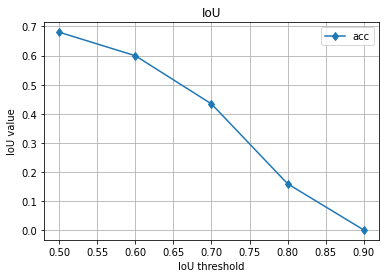

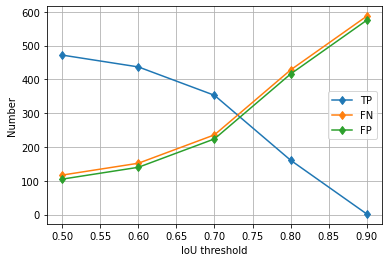

In [14]:
    #new image 
    from PIL import Image
    import matplotlib.pyplot as plt
    plt.figure(1)
    plt.plot(taus,AP,marker='d')
    plt.grid()

    plt.title('IoU')
    plt.ylabel('IoU value')
    plt.xlabel('IoU threshold')
    plt.legend(['acc'], loc='upper right')

    plt.figure(2)
    for m in M:
     plt.plot(taus,m,marker='d')
     plt.grid()

     #plt.title('The number of TP, FN and FP')
     plt.ylabel('Number')
     plt.xlabel('IoU threshold')
    plt.legend(['TP','FN','FP'], loc='center right')
    plt.show()